In [122]:
# Uploading Data from Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
# Installing Libraries

!pip install easyocr
!pip install opencv-python-headless
!pip install pandas

In [124]:
# Packages

import pandas as pd
import numpy as np
import easyocr
import cv2
import matplotlib.pyplot as plt
import os

## ***Preprocessing and Data Exploration***

In [125]:
# Paths to the datasets on Google Drive

car_images_path = '/content/drive/MyDrive/Assignment/Licplatesdetection_train'
car_annotations_path = '/content/drive/MyDrive/Assignment/Licplatesdetection_train.csv'
license_plate_images_path = '/content/drive/MyDrive/Assignment/Licplatesrecognition_train'
license_plate_annotations_path = '/content/drive/MyDrive/Assignment/Licplatesrecognition_train.csv'
test_images_path = '/content/drive/MyDrive/Assignment/test'

In [126]:
# Load annotations
car_annotations = pd.read_csv(car_annotations_path)
license_plate_annotations = pd.read_csv(license_plate_annotations_path)

In [127]:
# Function to load and visualize images and annotations
def load_image(image_path):
    return cv2.imread(image_path)

def plot_image_with_bbox(image, bbox, title="Image with Bounding Box"):
    ymin, xmin, ymax, xmax = bbox
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

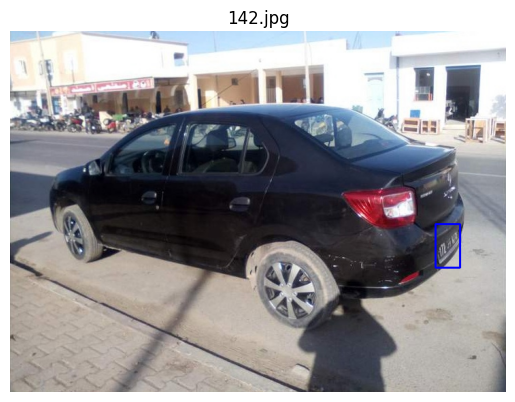

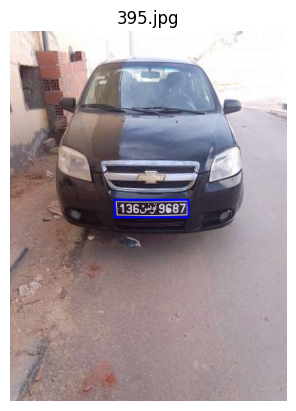

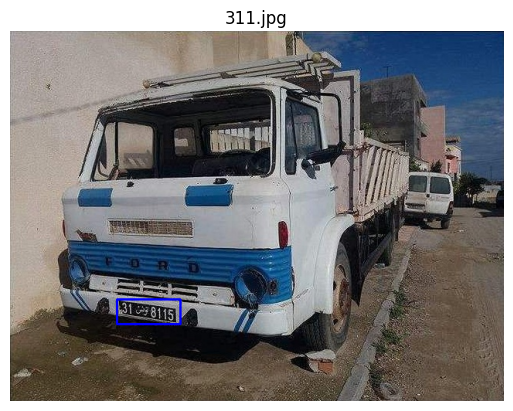

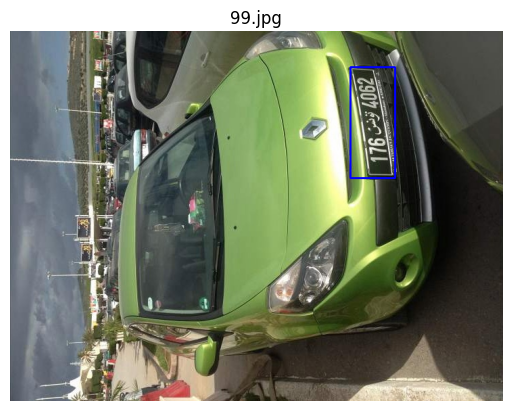

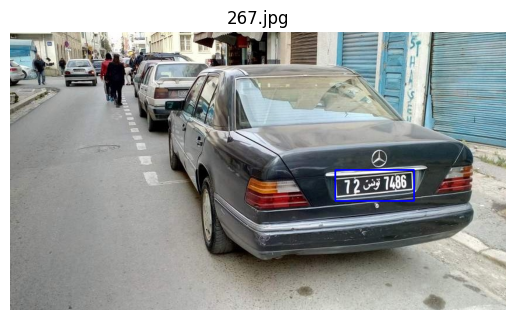

In [128]:
# Display some sample images with bounding boxes from Training Set 1
sample_images = car_annotations.sample(5)
for index, row in sample_images.iterrows():
    image_path = os.path.join(car_images_path, row['img_id'])
    image = load_image(image_path)
    bbox = [row['ymin'], row['xmin'], row['ymax'], row['xmax']]
    plot_image_with_bbox(image, bbox, title=row['img_id'])

In [129]:
# Explore the car annotations dataset
print("Car Annotations DataFrame:")
print(car_annotations.head())

Car Annotations DataFrame:
    img_id  ymin  xmin  ymax  xmax
0    1.jpg   276    94   326   169
1   10.jpg   311   395   344   444
2  100.jpg   406   263   450   434
3  101.jpg   283   363   315   494
4  102.jpg   139    42   280   222


In [130]:
# Check for any missing values in car annotations
print("\nMissing values in car annotations:")
print(car_annotations.isnull().sum())



Missing values in car annotations:
img_id    0
ymin      0
xmin      0
ymax      0
xmax      0
dtype: int64


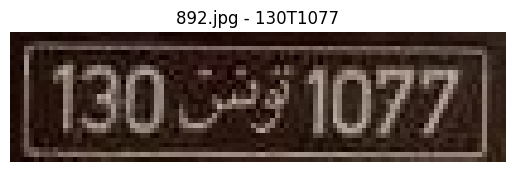

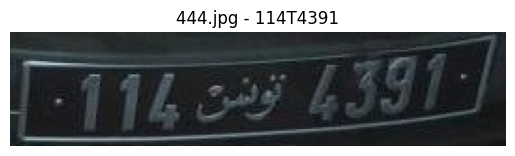

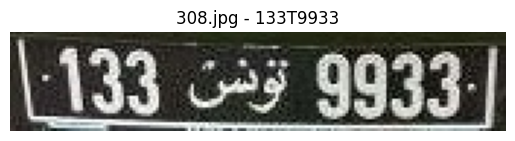

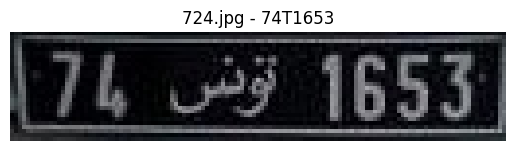

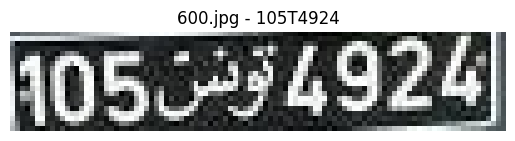

In [131]:
# Load and display some sample license plate images from Training Set 2
sample_license_plate_images = license_plate_annotations.sample(5)
for index, row in sample_license_plate_images.iterrows():
    image_path = os.path.join(license_plate_images_path, row['img_id'])
    image = load_image(image_path)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"{row['img_id']} - {row['text']}")
    plt.axis('off')
    plt.show()

In [132]:
# Explore the license plate annotations dataset
print("License Plate Annotations DataFrame:")
print(license_plate_annotations.head())

License Plate Annotations DataFrame:
    img_id      text
0    0.jpg  117T3989
1    1.jpg  128T8086
2   10.jpg   94T3458
3  100.jpg  133T6719
4  101.jpg   68T5979


In [133]:
# Check for any missing values in license plate annotations
print("\nMissing values in license plate annotations:")
print(license_plate_annotations.isnull().sum())


Missing values in license plate annotations:
img_id    0
text      0
dtype: int64


## ***License Plate Detection***

In [134]:
# Libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

In [135]:
# simple CNN model for object detection
def create_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    bbox_output = Dense(4, activation='linear')(x)
    model = Model(inputs, bbox_output)
    return model

input_shape = (224, 224, 3)
model = create_model(input_shape)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       7385

## ***Character Recognition***

In [139]:
# Packages
import easyocr

In [160]:
# Function to perform OCR on license plate images
reader = easyocr.Reader(['en', 'ar'])

# Function to recognize characters in the image
def recognize_characters(image):
    if isinstance(image, str):  # Check if the input is a file path
        image = cv2.imread(image)  # Load the image using OpenCV if it's a file path
    elif not isinstance(image, (np.ndarray, bytes)):  # Check if the input is a NumPy array or bytes
        raise ValueError('Invalid input type. Supporting format = string(file path or url), bytes, numpy array')

    result = reader.readtext(image)
    recognized_text = ' '.join([text for text, _, _ in result])
    return recognized_text

sample_image_filename = license_plate_annotations.iloc[0]['img_id'] + '.jpg'
sample_image_path = os.path.join(license_plate_images_path, sample_image_filename)

# Recognize characters in the image
recognized_text = recognize_characters(sample_image_path)
print(f"Recognized Text: {recognized_text}")

ValueError: Invalid input type. Supporting format = string(file path or url), bytes, numpy array